In [15]:
import os

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf,desc,row_number,col,year,month,dayofmonth,hour,dayofweek,to_timestamp,size,isnan,lit,date_format,to_timestamp,struct,expr
from pyspark.sql.types import MapType, StringType, IntegerType, StructType, StructField, FloatType, ArrayType, DoubleType

In [2]:
try:
    spark
except NameError:
    spark=SparkSession.builder.appName("").getOrCreate()

In [6]:
source='cuebiq'
country='US'

if os.getenv('CLUSTER')=='PRINCE':
    path_to_data='/scratch/spf248/covid/data'
    daily_file='part-00197-e15982a6-c3a9-4ce0-a9f4-3a991f6953c3-c000.snappy.parquet'
    personal_file='part-00070-00df9a9f-644d-4085-897b-e9bcdaddebe4-c000.snappy.parquet'
    geocoded_file='part-01192-333810a8-30e9-463c-8980-4c906b15aaed-c000.snappy.parquet'
    home_file='part-00178-be22e5f1-caff-48fa-8a17-37bebbd39117-c000.snappy.parquet'
    secondary_file='part-00181-ffd1e143-6210-4dd5-bc93-de8d6c777b23-c000.snappy.parquet'
else:
    path_to_data='/user/spf248/covid/data'
    daily_file='*'
    personal_file='*'
    geocoded_file='*'
    home_file='*'
    secondary_file='*'

In [79]:
counts_daily.groupby('date').count().show()

+----------+-----+
|      date|count|
+----------+-----+
|2020-02-26|90103|
|2020-04-13|    1|
|1000-01-30|    1|
|2302-06-02|    1|
|2202-01-09|    1|
|2902-03-04|    1|
|2018-12-31|    3|
|5520-02-11|    1|
|0277-12-10|    1|
|4800-02-29|    1|
|1995-01-26|    1|
|1995-01-25|    2|
|8280-01-22|    1|
|5970-01-03|    1|
|2020-01-05|88488|
|2021-10-25|    1|
|4220-03-02|    1|
|2021-02-18|    1|
|2018-12-20|    1|
|2020-04-12|    2|
+----------+-----+
only showing top 20 rows



In [7]:
counts_daily=spark.read.parquet(os.path.join(path_to_data,source,country,'counts_daily',daily_file))
counts_personal=spark.read.parquet(os.path.join(path_to_data,source,country,'counts_personal',personal_file))
personal_geocoded=spark.read.parquet(os.path.join(path_to_data,source,country,'personal_geocoded',geocoded_file))
personal_home=spark.read.parquet(os.path.join(path_to_data,source,country,'personal_home',home_file))
personal_secondary=spark.read.parquet(os.path.join(path_to_data,source,country,'personal_secondary',secondary_file))

In [19]:
personal_geocoded=personal_geocoded.withColumn('point',struct('longitude','latitude')).drop('longitude','latitude')
personal_home=personal_home.join(personal_geocoded,on=['cuebiq_id','point'])
personal_secondary=personal_secondary.join(personal_geocoded,on=['cuebiq_id','point'])

In [26]:
counts_daily_home=counts_daily.join(personal_home,on='cuebiq_id').drop('point')
counts_personal_home=counts_personal.join(personal_home,on=['cuebiq_id','point']).drop('point')

counts_daily_secondary=counts_daily.join(personal_secondary,on='cuebiq_id').drop('point')
counts_personal_secondary=counts_personal.join(personal_secondary,on=['cuebiq_id','point']).drop('point')

counts_home=counts_daily_home.join(
counts_personal_home.withColumnRenamed('n_pings','n_home'),on=['cuebiq_id','date','GEOID10'])

counts_secondary=counts_daily_secondary.join(
counts_personal_secondary.withColumnRenamed('n_pings','n_secondary'),on=['cuebiq_id','date','GEOID10'])

In [43]:
counts_home=counts_home.groupby('GEOID10','date').agg(
{'n_pings':'sum','n_home':'sum'}).withColumnRenamed(
'sum(n_home)','n_home').withColumnRenamed('sum(n_pings)','n_pings')
counts_home=counts_home.withColumn('pct_home',col('n_home')/col('n_pings'))

counts_secondary=counts_secondary.groupby('GEOID10','date').agg(
{'n_pings':'sum','n_secondary':'sum'}).withColumnRenamed(
'sum(n_secondary)','n_secondary').withColumnRenamed('sum(n_pings)','n_pings')
counts_secondary=counts_secondary.withColumn('pct_secondary',col('n_secondary')/col('n_pings'))

In [45]:
counts_home.write.mode("overwrite").parquet(os.path.join(path_to_data,source,country,'counts_home'))
counts_secondary.write.mode("overwrite").parquet(os.path.join(path_to_data,source,country,'counts_secondary'))

DataFrame[GEOID10: string, date: string, n_pings: bigint, n_secondary: bigint, pct_secondary: double]

In [81]:
counts_home=spark.read.parquet(os.path.join(path_to_data,source,country,'counts_home'))
counts_secondary=spark.read.parquet(os.path.join(path_to_data,source,country,'counts_secondary'))

In [99]:
counts_home=counts_home.groupby('date').agg({'pct_home':'mean','n_pings':'sum'}).toPandas()
counts_secondary=counts_secondary.groupby('date').agg({'pct_secondary':'mean','n_pings':'sum'}).toPandas()

In [100]:
counts_home=counts_home.sort_values(by='sum(n_pings)').tail(79)
counts_secondary=counts_secondary.sort_values(by='sum(n_pings)').tail(79)

In [101]:
counts_home.date=pd.to_datetime(counts_home.date,errors='ignore')
counts_secondary.date=pd.to_datetime(counts_secondary.date,errors='ignore')

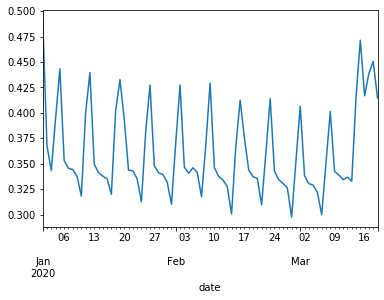

In [97]:
counts_home.set_index('date').sort_index()['avg(pct_home)'].plot()

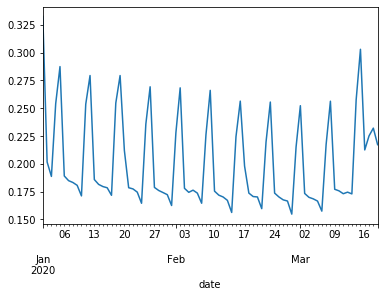

In [103]:
counts_secondary.set_index('date').sort_index()['avg(pct_secondary)'].plot()